In [1]:
# -*- coding: utf-8 -*-
# -*- author : Vincent Roduit - Fabio Palmisano -*-
# -*- date : 2024-01-20 -*-
# -*- Last revision: 2024-01-20 (Vincent Roduit)-*-
# -*- python version : 3.11.6 -*-
# -*- Description: Notebook that summarizes results-*-

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/EE-411-FOIL-Project/source

/content/drive/MyDrive/EE-411-FOIL-Project/source


# <center> EE - 411: Fundamentals of Inference and Learning </center>
## <center> Ecole Polytechnique Fédérale de Lausanne </center>
### <center>Deep Double Descent: When Bigger Models and More Data Hurt </center>
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import librairies
import os
import torchvision
import seaborn as sns
import numpy as np

In [3]:
# Import files
from training_utils import*
from functions import*
from display_functions import*
from data_utils import*
from data_classes import*

# 1. Introduction

## 1.1 Vizualize the Dataset

### 1.1.1 Define class dictionaries

In [4]:
MNIST = NoisyMNIST()
CIFAR10 = NoisyCIFAR10()
CIFAR100 = NoisyCIFAR100()

Files already downloaded and verified
Files already downloaded and verified


In [5]:
#CIFAR-10
metadata_path = '../data/datasets/cifar-10-batches-py/batches.meta'
metadata = unpickle(metadata_path)
cifar10_dict = [label.decode('utf-8') for label in metadata[b'label_names']]

#CIFAR-100
metadata_path = '../data/datasets/cifar-100-python/meta'
metadata = unpickle(metadata_path)
cifar100_dict = [label.decode('utf-8') for label in metadata[b'fine_label_names']]

### 1.1.2 Vizualize Datasets

#### MNIST

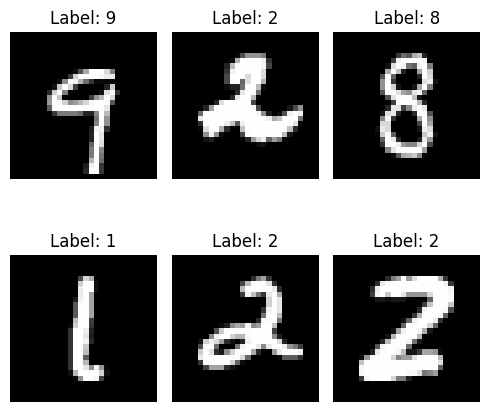

In [ ]:
visualize_dataset((np.array(MNIST.mnist.data), np.array(MNIST.mnist.targets)), num_images=6)

#### CIFAR 10

Files already downloaded and verified


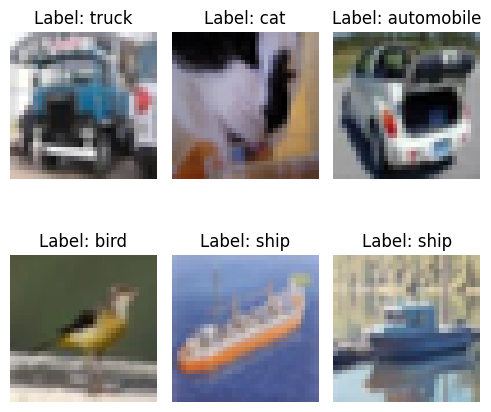

In [ ]:
visualize_dataset((np.array(CIFAR10.cifar10.data), np.array(CIFAR10.cifar10.targets)), num_images=6,label_names=cifar10_dict)

#### CIFAR 100

Files already downloaded and verified


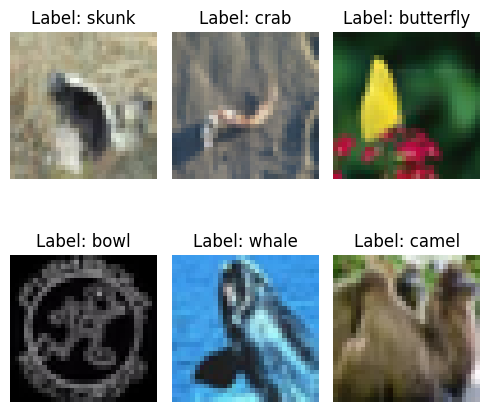

In [ ]:
visualize_dataset((np.array(CIFAR100.cifar100.data), np.array(CIFAR100.cifar100.targets)), num_images=6,label_names=cifar100_dict)

## 1.2 Effect of transformation

### 1.2.1 Horizontal Flip

Files already downloaded and verified


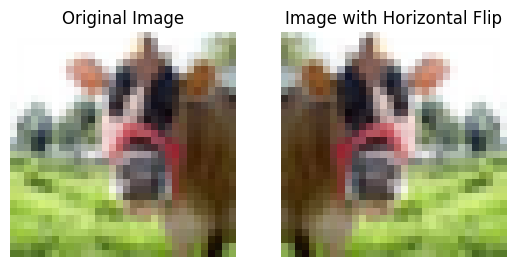

In [ ]:
#Define transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Load CIFAR100 dataset
cifar100_dataset = torchvision.datasets.CIFAR100(root='../data/datasets', train=True, download=True, transform=transform)

#Random image
image1, _ = cifar100_dataset[0]
image2, _ = cifar100_dataset[1]

#Define RandomHorizontalFlip
horizontal_flip = torchvision.transforms.RandomHorizontalFlip(p=1)

#Apply RandomHorizontalFlip only to image1
image1_flip = horizontal_flip(image1)

#Plot images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image1.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image1_flip.permute(1, 2, 0))
axes[1].set_title('Image with Horizontal Flip')
axes[1].axis('off')

plt.savefig(os.path.join(constants.RESULTS_FOLDER + 'horizontal_flip.png'))

plt.show()


#### Random Crop

Files already downloaded and verified


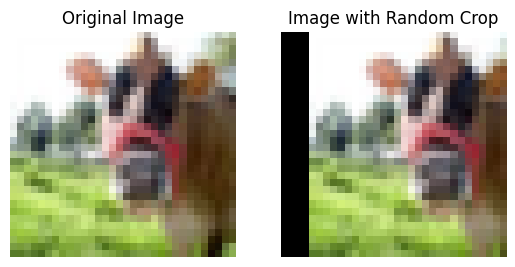

In [ ]:
#Define transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# Load CIFAR100 dataset
cifar100_dataset = torchvision.datasets.CIFAR100(root='../data/datasets', train=True, download=True, transform=transform)

#Random image
image1, _ = cifar100_dataset[0]
image2, _ = cifar100_dataset[1]

#Define RandomCrop
random_crop = torchvision.transforms.RandomCrop(size=32, padding=4)

#Apply RandomCrop only to image1
image1_crop = random_crop(image1)

#Plot images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(image1.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image1_crop.permute(1, 2, 0))
axes[1].set_title('Image with Random Crop')
axes[1].axis('off')

plt.savefig(os.path.join(constants.RESULTS_FOLDER + 'random_crop.png'))

plt.show()


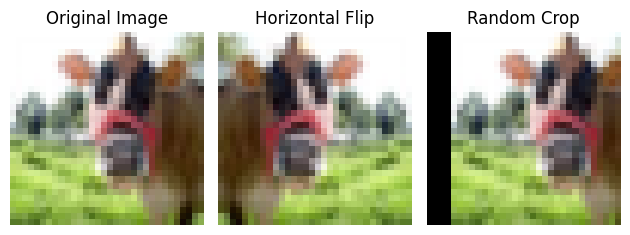

In [ ]:
#Plot images
fig, axes = plt.subplots(1, 3)
axes[0].imshow(image1.permute(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image1_flip.permute(1, 2, 0))
axes[1].set_title('Horizontal Flip')
axes[1].axis('off')
axes[2].imshow(image1_crop.permute(1, 2, 0))
axes[2].set_title('Random Crop')
axes[2].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(constants.RESULTS_FOLDER + 'augmentations.png'))

# 2. Preliminary Experiments

## 2.1 Required time

#### CIFAR10 on T4

In [ ]:
train_losses, test_losses,predictions = model_convergence(
                                            optimizer='Adam', 
                                            model='ResNet',
                                            dataset_name='CIFAR10',
                                            num_epochs=2, 
                                            noise_ratio=0.1, 
                                            width=30)

Training model


Epoch 2/2: Loss = 1.3775345885845096 Time = 19.818259716033936

Files already downloaded and verified
Files already downloaded and verified
Training done. Duration: 0:00:45.022687


#### CIFAR10 on V100

In [ ]:
train_losses, test_losses,predictions = model_convergence(
                                            optimizer='Adam', 
                                            model='ResNet',
                                            dataset_name='CIFAR10',
                                            num_epochs=2, 
                                            noise_ratio=0.1, 
                                            width=30)

Training model


Epoch 2/2: Loss = 1.336942644527806 Time = 12.713595151901245

Files already downloaded and verified
Files already downloaded and verified
Training done. Duration: 0:00:47.235670


#### CIFAR100 on T4

In [ ]:
train_losses, test_losses,predictions = model_convergence(
                                            optimizer='Adam',
                                            model='ResNet',
                                            dataset_name='CIFAR100',
                                            num_epochs=2, 
                                            noise_ratio=0.1, 
                                            width=30)

Training model


Epoch 2/2: Loss = 3.49663988891465 Time = 19.915818214416504

Files already downloaded and verified
Files already downloaded and verified
Training done. Duration: 0:00:44.956707


#### CIFAR100 on V100

In [ ]:

train_losses, test_losses,predictions = model_convergence(
                                            optimizer='Adam', 
                                            model='ResNet',
                                            dataset_name='CIFAR100',
                                            num_epochs=2, 
                                            noise_ratio=0.1, 
                                            width=30)

Training model


Epoch 2/2: Loss = 3.4420123978344073 Time = 13.003688097000122

Files already downloaded and verified
Files already downloaded and verified
Training done. Duration: 0:00:46.741617


MNIST on T4

In [ ]:
train_losses, test_losses,predictions = model_convergence(
                                            optimizer='Adam', 
                                            model='ResNet',
                                            dataset_name='MNIST',
                                            num_epochs=2, 
                                            noise_ratio=0.1, 
                                            width=30)

Training model


Epoch 2/2: Loss = 0.577136723358003 Time = 16.613971710205078

Training done. Duration: 0:00:34.591217


#### MNIST on V100

In [ ]:
train_losses, test_losses,predictions = model_convergence(
                                            optimizer='Adam', 
                                            model='ResNet',
                                            dataset_name='MNIST',
                                            num_epochs=2, 
                                            noise_ratio=0.1,
                                              width=30)

Training model


Epoch 2/2: Loss = 0.5762918376556748 Time = 10.132039308547974

Training done. Duration: 0:00:28.658639


## 2.2 Testing the Convergence

### For k (*Width Parameter*) = 4
with 50'000 samples for train and 10'000 samples for test

We use a new function model_convergence that return us, Losses for each epoch, then the test losses and the accuracy of the model.

In [ ]:
losses_k4, test_loss_k4,test_accuracy_k4 = model_convergence(optimizer='Adam', model='ResNet',dataset_name='CIFAR10',
                                                                num_epochs=1000, noise_ratio=0.2, width=4)

### Obtain pre computed results stored as pickle files
As the computation of these figures is time expensive, results are stored in pickle format in order to plot without computing each time

In [31]:
#Load Data from Pickle for 200 Epochs runs and k = 4
losses_k4_200E = open_pickle(os.path.join(constants.CONVERGENCE_FOLDER,'losses_k4_200E.pkl'))
test_loss_k4_200E = open_pickle(os.path.join(constants.CONVERGENCE_FOLDER,'test_loss_k4_200E.pkl'))
test_accuracy_k4_200E = open_pickle(os.path.join(constants.CONVERGENCE_FOLDER,'test_accuracy_k4_200E.pkl'))

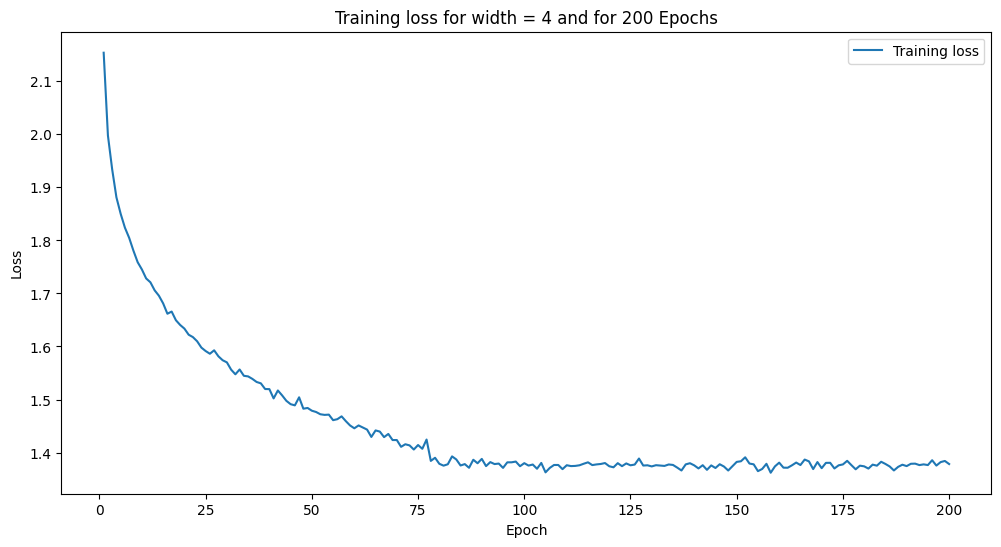

In [32]:
#Visualize convergence for 200 Epochs
visualize_convergence(losses_k4_200E,test_loss_k4_200E, test_accuracy_k4_200E, num_epochs = 200, width = 4)

### For k (*Width Parameter*) = 10

In [ ]:
losses_k10, test_loss_k10,test_accuracy_k10 = model_convergence(optimizer='Adam', model='ResNet',dataset_name='CIFAR10',
                                                                num_epochs=1000, noise_ratio=0.2, width=10)

In [33]:
## Load Data from Pickle for 200 Epochs runs and k = 10
losses_k10_200E = open_pickle(os.path.join(constants.CONVERGENCE_FOLDER,'losses_k10_200E.pkl'))
test_loss_k10_200E = open_pickle(os.path.join(constants.CONVERGENCE_FOLDER,'test_loss_k10_200E.pkl'))
test_accuracy_k10_200E = open_pickle(os.path.join(constants.CONVERGENCE_FOLDER,'test_accuracy_k10_200E.pkl'))

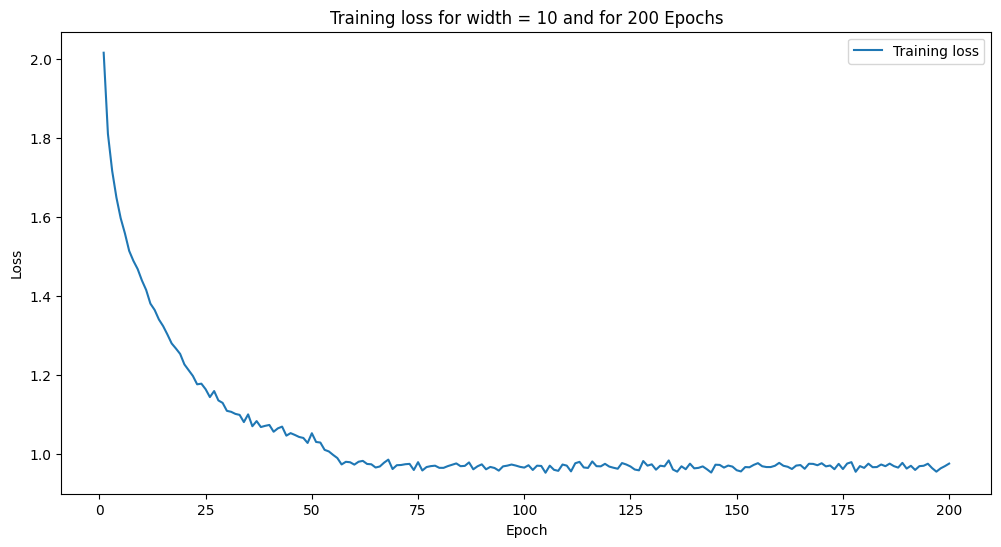

In [34]:
#Visualize convergence for 200 Epochs
visualize_convergence(losses_k10_200E, test_loss_k10_200E, test_accuracy_k10_200E, num_epochs=200, width = 10)

## 2.3 Result with/without Scheduler

#### No label noise

In [ ]:
train_losses_without, test_losses_without,predictions_without = model_convergence(
                                                                    optimizer='Adam', 
                                                                    model='ResNet',
                                                                    dataset_name='CIFAR10',
                                                                    num_epochs=30, 
                                                                    noise_ratio=0, 
                                                                    width=32)
                                                                    
train_losses_with, test_losses_with,predictions_with = model_convergence(
                                                                    optimizer='Adam', 
                                                                    model='ResNet',
                                                                    dataset_name='CIFAR10',
                                                                    num_epochs=30, 
                                                                    noise_ratio=0, 
                                                                    width=32,
                                                                    scheduler=True)


Training model


Epoch 30/30: Loss = 0.03317055135356176 Time = 16.932536840438843

Files already downloaded and verified
Files already downloaded and verified
Training done. Duration: 0:08:38.090063


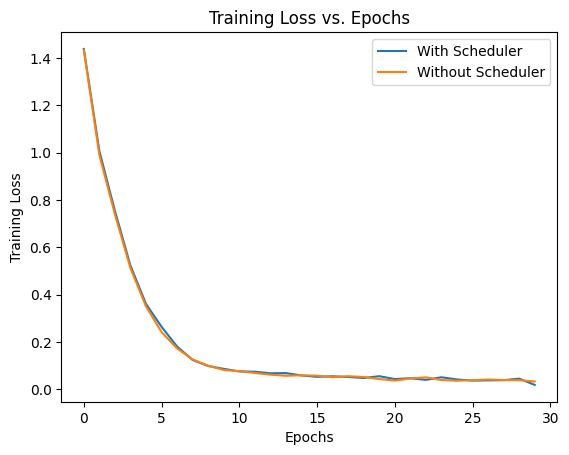

In [ ]:
sns.lineplot(x=range(len(train_losses_with)), y=train_losses_with, label='With Scheduler')
sns.lineplot(x=range(len(train_losses_without)), y=train_losses_without, label='Without Scheduler')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs')
plt.savefig(os.path.join(constants.RESULTS_FOLDER, 'train_loss_scheduler_0noise.png'))
plt.show()

In [ ]:
print(f'Predictions without scheduler: {predictions_without}')
print(f'Predictions with scheduler: {predictions_with}')

Predictions without scheduler: 67.83999633789062
Predictions with scheduler: 70.88999938964844


#### With label noise (20%)

In [ ]:
train_losses_without, test_losses_without,predictions_without = model_convergence(
                                                                    optimizer='Adam',
                                                                    model='ResNet',
                                                                    dataset_name='CIFAR10',
                                                                    num_epochs=30, 
                                                                    noise_ratio=0.2, 
                                                                    width=32)

train_losses_with, test_losses_with,predictions_with = model_convergence(
                                                                    optimizer='Adam',
                                                                    model='ResNet',
                                                                    dataset_name='CIFAR10',
                                                                    num_epochs=30, 
                                                                    noise_ratio=0.2, 
                                                                    width=32,
                                                                    scheduler=True)


Training model


Epoch 30/30: Loss = 0.9547855793057806 Time = 17.782148361206055

Files already downloaded and verified
Files already downloaded and verified
Training done. Duration: 0:09:01.879214
Training model


Epoch 30/30: Loss = 0.917752689260351 Time = 17.68877649307251

Files already downloaded and verified
Files already downloaded and verified
Training done. Duration: 0:08:58.222820


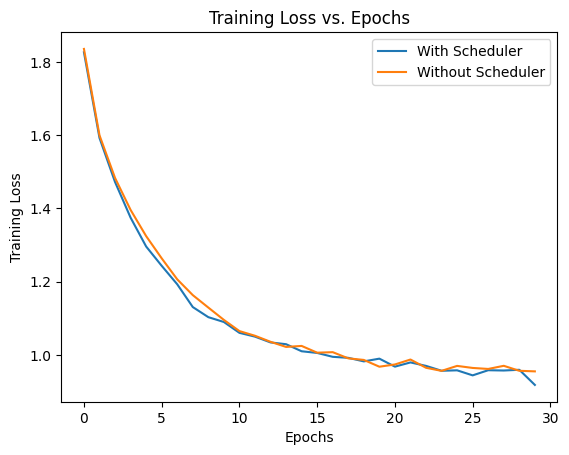

In [ ]:
sns.lineplot(x=range(len(train_losses_with)), y=train_losses_with, label='With Scheduler')
sns.lineplot(x=range(len(train_losses_without)), y=train_losses_without, label='Without Scheduler')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs')
plt.savefig(os.path.join(constants.RESULTS_FOLDER, 'train_loss_scheduler_20noise.png'))
plt.show()

In [ ]:
print(f'Predictions without scheduler: {predictions_without}')
print(f'Predictions with scheduler: {predictions_with}')

Predictions without scheduler: 57.64999771118164
Predictions with scheduler: 62.349998474121094


## 2.4 Convergence with reduced datasets

In [ ]:
constants.NUM_TRAIN_SAMPLES = 10000
constants.NUM_TEST_SAMPLES = 2000
train_losses_32, test_losses_32,predictions_32 = model_convergence(
                                                    optimizer='Adam', 
                                                    model='ResNet',
                                                    dataset_name='MNIST',
                                                    num_epochs=120, 
                                                    noise_ratio=0.2, 
                                                    width=32,
                                                    scheduler=True)
train_losses_4, test_losses_4,predictions_4 = model_convergence(
                                                optimizer='Adam', 
                                                model='ResNet',
                                                dataset_name='MNIST',
                                                num_epochs=120,
                                                noise_ratio=0.2, 
                                                width=4,s
                                                cheduler=True)
train_losses_64, test_losses_64,predictions_64 = model_convergence(
                                                optimizer='Adam', 
                                                model='ResNet',
                                                dataset_name='MNIST',
                                                num_epochs=120,
                                                noise_ratio=0.2, 
                                                width=64,
                                                scheduler=True)

Training model


Epoch 24/120: Loss = 0.9001196977458422 Time = 3.413876533508301

Early stopping at epoch 25
Training done. Duration: 0:01:23.686064
Training model


Epoch 27/120: Loss = 0.9711502994163127 Time = 1.9426302909851074

Early stopping at epoch 28
Training done. Duration: 0:01:00.167388
Training model


Epoch 22/120: Loss = 0.8791572534585301 Time = 6.98637318611145

Early stopping at epoch 23
Training done. Duration: 0:02:37.086751


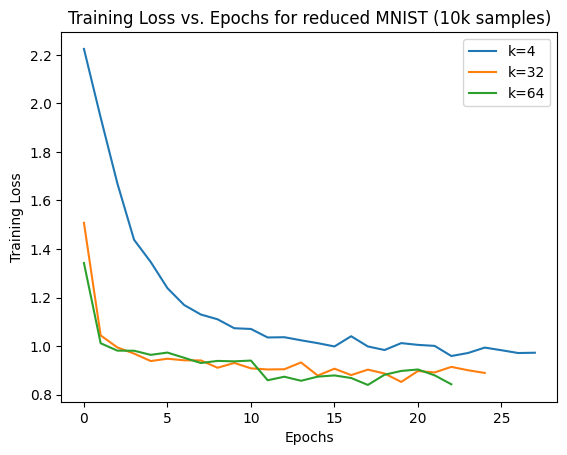

In [ ]:
sns.lineplot(x=range(len(train_losses_4)), y=train_losses_4,label='k=4')
sns.lineplot(x=range(len(train_losses_32)), y=train_losses_32,label='k=32')
sns.lineplot(x=range(len(train_losses_64)), y=train_losses_64,label='k=64')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs for reduced MNIST (10k samples)')
plt.savefig(os.path.join(constants.RESULTS_FOLDER, 'train_loss_reduced_mnist.png'))
plt.show()

In [ ]:
constants.NUM_TRAIN_SAMPLES = 10000
constants.NUM_TEST_SAMPLES = 2000
train_losses_32, test_losses_32,predictions_32 = model_convergence(
                                                    optimizer='Adam', 
                                                    model='ResNet',
                                                    dataset_name='CIFAR10',
                                                    num_epochs=120, 
                                                    noise_ratio=0.2, 
                                                    width=32,
                                                    scheduler=True)
train_losses_4, test_losses_4,predictions_4 = model_convergence(
                                                optimizer='Adam',
                                                  model='ResNet',
                                                  dataset_name='CIFAR10',
                                                  num_epochs=120, 
                                                  noise_ratio=0.2, 
                                                  width=4,
                                                  scheduler=True)
train_losses_64, test_losses_64,predictions_64 = model_convergence(
                                                    optimizer='Adam', 
                                                    model='ResNet',
                                                    dataset_name='CIFAR10',
                                                    num_epochs=120,
                                                    noise_ratio=0.2, 
                                                    width=64,
                                                    scheduler=True)



Training model


Epoch 42/120: Loss = 0.9267959971971149 Time = 4.136446952819824

Files already downloaded and verified
Files already downloaded and verified
Early stopping at epoch 43
Training done. Duration: 0:02:47.709718
Training model


Epoch 89/120: Loss = 1.2936316509790058 Time = 3.495530605316162

Files already downloaded and verified
Files already downloaded and verified
Early stopping at epoch 90
Training done. Duration: 0:04:01.559330
Training model


Epoch 39/120: Loss = 0.9043024069146265 Time = 8.265464544296265

Files already downloaded and verified
Files already downloaded and verified
Early stopping at epoch 40
Training done. Duration: 0:05:27.542225


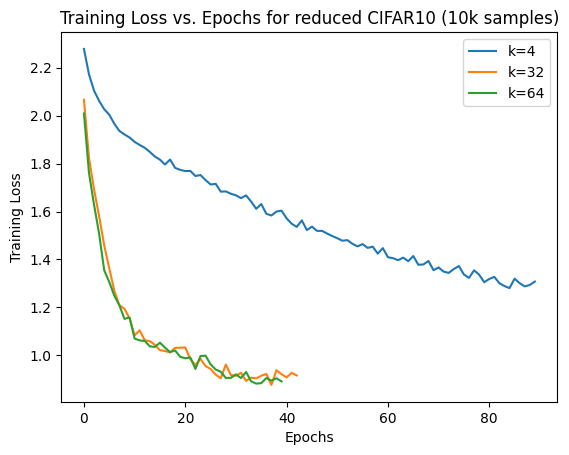

In [ ]:
sns.lineplot(x=range(len(train_losses_4)), y=train_losses_4,label='k=4')
sns.lineplot(x=range(len(train_losses_32)), y=train_losses_32,label='k=32')
sns.lineplot(x=range(len(train_losses_64)), y=train_losses_64,label='k=64')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss vs. Epochs for reduced CIFAR10 (10k samples)')
plt.savefig(os.path.join(constants.RESULTS_FOLDER, 'train_loss_reduced_CIFAR10.png'))
plt.show()

# 3. Figure 4

## 3.1 Reduced experiment

In [11]:
width_model_list = np.linspace(1, 64, 30,dtype=int)
noise_ratio_list = [0,0.1,0.2]
constants.NUM_EPOCHS = 100
constants.NUM_TRAIN_SAMPLES = 10000
constants.NUM_TEST_SAMPLES = 2000

In [12]:
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list,
                                                                             width_model_list,
                                                                             optimizer_name='Adam',
                                                                             model='ResNet',
                                                                             dataset_name='MNIST')

Model with noise ratio 0


Training for width 64/64

Epoch 29/100: Loss = 0.000104850306066694 Time = 6.833048105239868

Noise ratio 0 done. Duration: 0:50:18.620174
******************
Model with noise ratio 0.1


Training for width 64/64

Epoch 31/100: Loss = 0.5255605819859083 Time = 7.040445566177368

Noise ratio 0.1 done. Duration: 0:53:46.680370
******************
Model with noise ratio 0.2


Training for width 64/64

Epoch 33/100: Loss = 0.865949078451229 Time = 6.904725551605225

Noise ratio 0.2 done. Duration: 0:56:28.679848
******************


In [13]:
save_pickle(train_losses, os.path.join(constants.FIG4_FOLDER, 'train_losses.pkl'))
save_pickle(train_accuracies, os.path.join(constants.FIG4_FOLDER, 'train_accuracies.pkl'))
save_pickle(test_losses, os.path.join(constants.FIG4_FOLDER, 'test_losses.pkl'))
save_pickle(test_accuracies, os.path.join(constants.FIG4_FOLDER, 'test_accuracies.pkl'))

#### Obtain pre computed results stored as pickle files
As the computation of these figures is time expensive, results are stored in pickle format in order to plot without computing each time

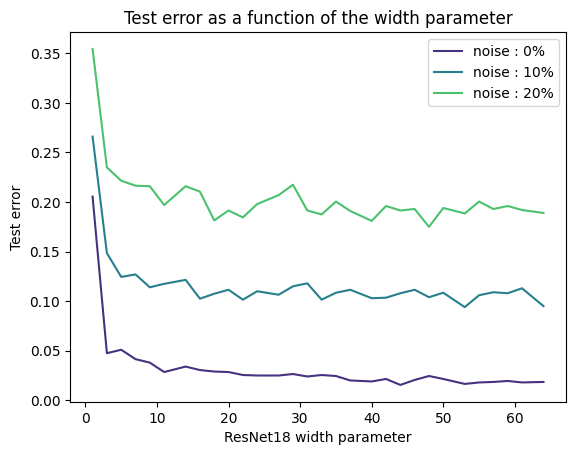

In [5]:
width_model_list = np.linspace(1, 64, 30,dtype=int)
noise_ratio_list = [0,0.1,0.2]
test_accuracies_path = os.path.join(constants.FIG4_FOLDER, 'test_accuracies.pkl')
test_accuracies = open_pickle(test_accuracies_path)
test_errors = (100 - np.array(test_accuracies)) / 100
display_error(error_lists=test_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=False)

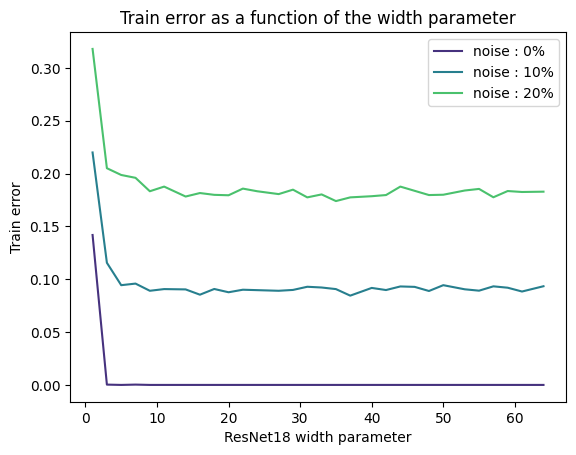

In [10]:
train_accuracies_path = os.path.join(constants.FIG4_FOLDER, 'train_accuracies.pkl')
train_accuracies = open_pickle(train_accuracies_path)
train_errors = (100 - np.array(train_accuracies)) / 100
display_error(error_lists=train_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=True)

## 3.2 Original Figure

In [ ]:
constants.NUM_EPOCHS = 4000
constants.NUM_TRAIN_SAMPLES = 50000
constants.NUM_TEST_SAMPLES = 10000

noise_ratio_list = [0,0.1,0.2]
width_model_list = np.arange(1,65)

train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list,
                                                                                width_model_list,
                                                                                optimizer='Adam',
                                                                                model='ResNet',
                                                                                dataset_name='CIFAR10')

In [ ]:
train_errors = (100 - np.array(train_accuracies)) / 100
test_errors = (100 - np.array(test_accuracies)) / 100
display_error(error_lists=train_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=True)
display_error(error_lists=test_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=False)

In [ ]:
noise_ratio_list = [0,0.05,0.1,0.15,0.2]
width_model_list = np.arange(1,65)
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list,
                                                                                width_model_list,
                                                                                optimizer='Adam',
                                                                                model='ResNet',
                                                                                dataset_name='CIFA100')

#### Obtain pre computed results stored as pickle files
As the computation of these figures is time expensive, results are stored in pickle format in order to plot without computing each time

In [ ]:
train_errors = (100 - np.array(train_accuracies)) / 100
test_errors = (100 - np.array(test_accuracies)) / 100
display_error(error_lists=train_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=True)
display_error(error_lists=test_errors,width_model_list=width_model_list,noise_ratio_list=noise_ratio_list,train=False)

# 4. Figure 6 : SGD vs Adam

## 4.1 Reduced experiment

In [ ]:
width_model_list = np.linspace(1, 64, 30,dtype=int)
noise_ratio_list = [0]
constants.NUM_EPOCHS = 100
constants.NUM_TRAIN_SAMPLES = 10000
constants.NUM_TEST_SAMPLES = 2000

In [ ]:
# Train model on CIFAR10 with CNN model and Adam optimizer
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list,
                                                                            width_model_list,
                                                                            optimizer = 'Adam',
                                                                            model='CNN',
                                                                            dataset_name='CIFAR10')

In [ ]:
save_pickle(train_losses, os.path.join(constants.FIG6_FOLDER,'train_losses_adam.pkl'))
save_pickle(train_accuracies, os.path.join(constants.FIG6_FOLDER,'train_accuracies_adam.pkl'))
save_pickle(test_losses, os.path.join(constants.FIG6_FOLDER,'test_losses_adam.pkl'))
save_pickle(test_accuracies, os.path.join(constants.FIG6_FOLDER,'test_accuracies_adam.pkl'))

In [ ]:
# Train model on CIFAR10 with CNN model and SGD optimizer
train_losses_SGD, train_accuracies_SGD, test_losses_SGD, test_accuracies_SGD = train_models(noise_ratio_list,
                                                                                            width_model_list,
                                                                                            optimizer = 'SGD',
                                                                                            model='CNN',
                                                                                            dataset_name='CIFAR10')

In [ ]:
save_pickle(train_losses_SGD, os.path.join(constants.FIG6_FOLDER,'train_losses_SGD.pkl'))
save_pickle(train_accuracies_SGD, os.path.join(constants.FIG6_FOLDER,'train_accuracies_SGD.pkl'))
save_pickle(test_losses_SGD, os.path.join(constants.FIG6_FOLDER,'test_losses_SGD.pkl'))
save_pickle(test_accuracies_SGD, os.path.join(constants.FIG6_FOLDER,'test_accuracies_SGD.pkl'))

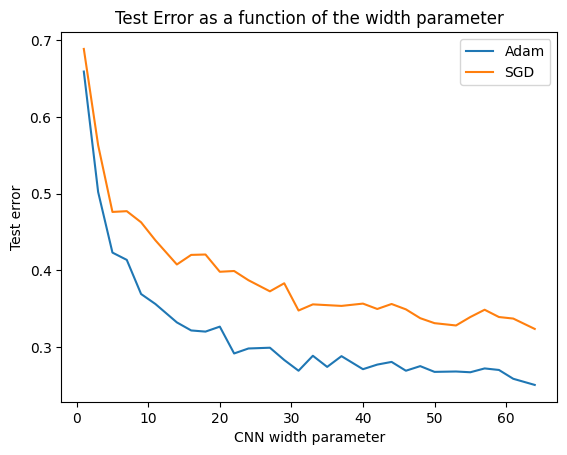

In [21]:
width_model_list = np.linspace(1, 64, 30,dtype=int)
noise_ratio_list = [0]
test_acc_sgd = open_pickle(os.path.join(constants.FIG6_FOLDER, 'test_accuracies_adam.pkl'))
test_acc_adam = open_pickle(os.path.join(constants.FIG6_FOLDER, 'test_accuracies_SGD.pkl'))
test_error_sgd = (100 - np.array(test_acc_sgd)) / 100
test_error_adam = (100 - np.array(test_acc_adam)) / 100

display_optimizer_stats(test_error_adam[0],test_error_sgd[0],width_model_list)

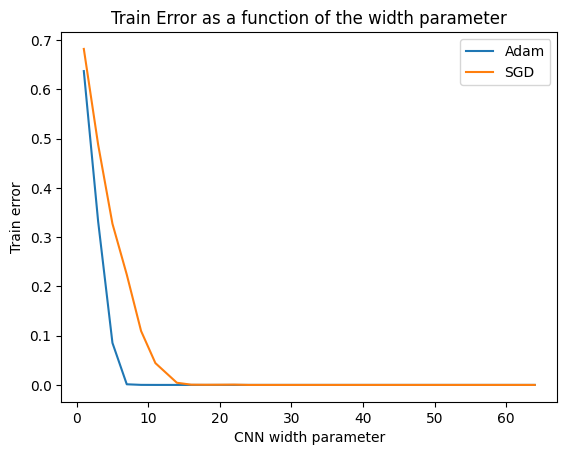

In [24]:
width_model_list = np.linspace(1, 64, 30,dtype=int)
noise_ratio_list = [0]
train_acc_sgd = open_pickle(os.path.join(constants.FIG6_FOLDER, 'train_accuracies_adam.pkl'))
train_acc_adam = open_pickle(os.path.join(constants.FIG6_FOLDER, 'train_accuracies_SGD.pkl'))
train_error_sgd = (100 - np.array(train_acc_sgd)) / 100
train_error_adam = (100 - np.array(train_acc_adam)) / 100

display_optimizer_stats(train_error_adam[0],train_error_sgd[0],width_model_list,train=True)

## 4.2 Original experiment

In [ ]:
width_model_list = np.arange(1,65)
constants.NUM_EPOCHS = 4000
constants.NUM_TRAIN_SAMPLES = 50000
constants.NUM_TEST_SAMPLES = 10000
train_losses, train_accuracies, test_losses, test_accuracies = train_models(noise_ratio_list,
                                                                            width_model_list,
                                                                            optimizer = 'Adam',
                                                                            model='CNN',
                                                                            dataset_name='CIFAR10')
constants.NUM_EPOCHS = 500000
train_losses_SGD, train_accuracies_SGD, test_losses_SGD, test_accuracies_SGD = train_models(noise_ratio_list,
                                                                                            width_model_list,
                                                                                            optimizer = 'SGD',
                                                                                            model='CNN',
                                                                                            dataset_name='CIFAR10')

test_error_sgd = (100 - np.array(test_acc_sgd)) / 100
test_error_adam = (100 - np.array(test_acc_adam)) / 100

display_optimizer_stats(test_error_adam,test_error_sgd,width_model_list)